In [16]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPool2D,Flatten,Dense,Dropout,BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping
import seaborn as sns

TO DOWNLOAD THE DATASET,PLEASE GO TO:https://www.kaggle.com/datamunge/sign-language-mnist/download

In [2]:
df_train = pd.read_csv('E:/Sign_L_MNIST/sign_mnist_train.csv')
df_test = pd.read_csv('E:/Sign_L_MNIST/sign_mnist_test.csv')

In [3]:
df_train.rename(columns={'label':'Label'},inplace = True)
df_test.rename(columns={'label':'Label'},inplace = True)

df_train = df_train.sample(frac = 1.0).reset_index(drop = True)
df_test = df_test.sample(frac = 1.0).reset_index(drop = True)

In [15]:
print(f'Number of train_images:{df_train.shape[0]}')
print(f"Number of test_images:{df_test.shape[0]}")
pix = int(np.sqrt(df_train.shape[1]-1))
print(f'Resolution of Images:{pix} X {pix}')

Number of train_images:27455
Number of test_images:7172
Resolution of Images:28 X 28


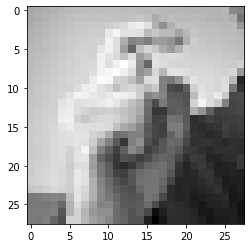

In [19]:
def to_image(array):
    array = np.array(array)
    return array[1:].reshape(28,28).astype(float)
img = to_image(df_train.iloc[0])
plt.imshow(img,cmap= 'gray')
plt.show()

In [6]:
alphab = 'abcdefghijklmnopqrstuvwxyz'
map_labels = {}
for i,l in enumerate(alphab):
    map_labels[l] = i
map_labels = {v:k for k,v in map_labels.items()}

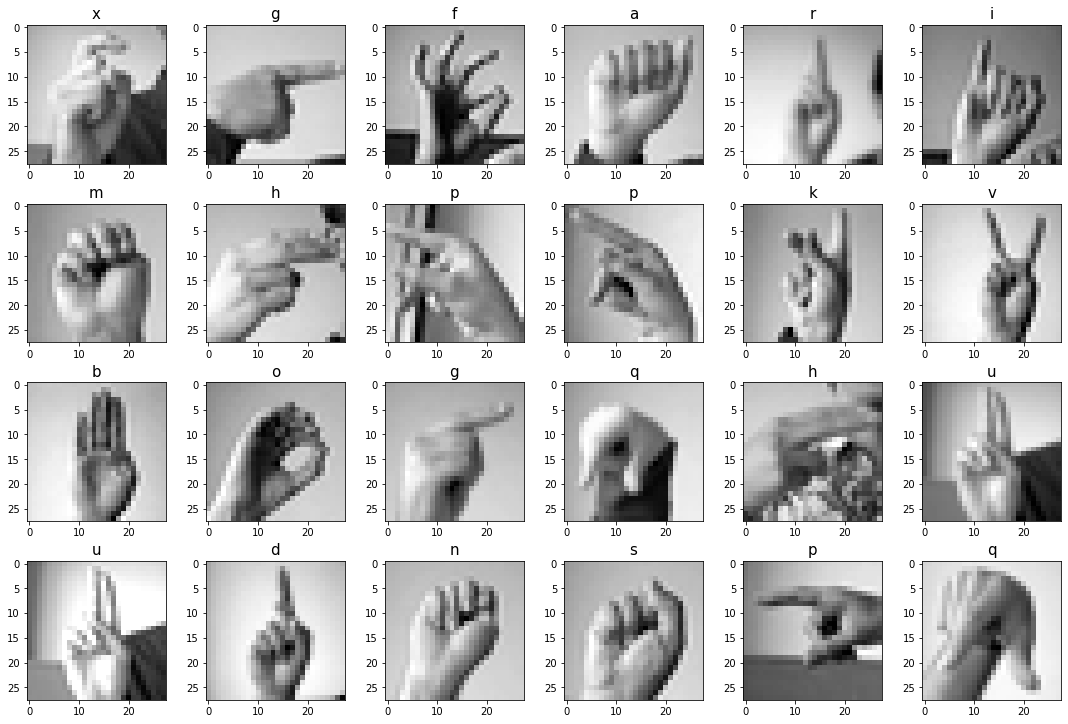

In [7]:
fig,axes = plt.subplots(nrows = 4,ncols = 6, figsize = (15,10))
for i,j in enumerate(axes.flat):
    img = to_image(df_train.iloc[i])
    j.imshow(img,cmap = 'gray')
    title = map_labels[df_train.Label[i]]
    j.set_title(title,fontsize = 15)
plt.tight_layout(pad=0.5)
plt.show()

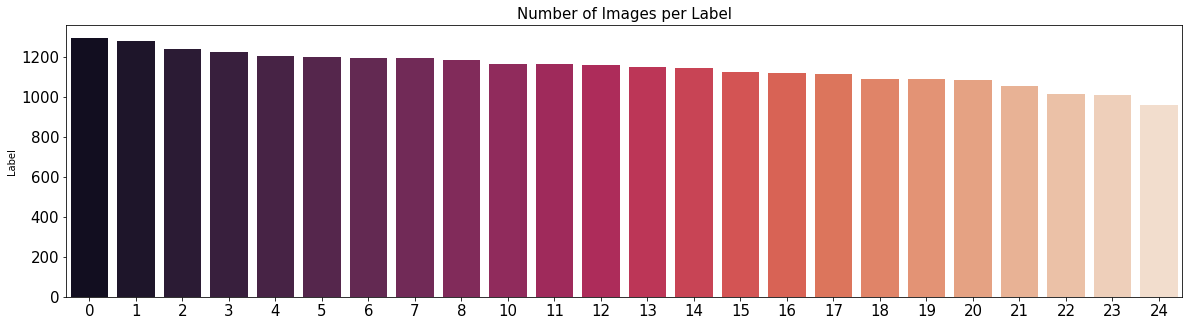

In [8]:
label_counts = df_train['Label'].value_counts()
plt.figure(figsize=(20,5))
sns.barplot(x=sorted(label_counts.index),y = label_counts,palette='rocket')
plt.title("Number of Images per Label",fontsize = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.show()

In [9]:
df_train_copy = df_train.copy()
val_index = int(df_train_copy.shape[0]*0.1)
df_train_split = df_train.iloc[val_index:]
df_val_split = df_train.iloc[:val_index]
y_train = df_train_split['Label']
y_val = df_val_split['Label']
y_test = df_test['Label']
X_train = df_train_split.drop('Label',axis = 1).values.reshape(df_train_split.shape[0],28,28,1)
X_val = df_val_split.drop('Label',axis = 1).values.reshape(df_val_split.shape[0],28,28,1)
X_test = df_test.drop('Label',axis = 1).values.reshape(df_test.shape[0],28,28,1)
y_train.shape

(24710,)

In [10]:
img_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255,rotation_range=10,
                                                               zoom_range=0.1,width_shift_range=0.1,
                                                               height_shift_range=0.1,shear_range=0.1,
                                                               horizontal_flip=False,fill_mode='nearest')
X_train_flow = img_generator.flow(X_train,y_train,batch_size = 32)
X_val_flow = img_generator.flow(X_val,y_val,batch_size = 32)

In [ ]:
model_cnn = Sequential([Conv2D(filters= 32,kernel_size = (3,3),activation ='relu',input_shape = (28,28,1)),
                       MaxPool2D(2,2,padding ='same'),
                       Conv2D(filters= 128,kernel_size = (3,3),activation ='relu'),
                       MaxPool2D(2,2,padding ='same'),
                       Conv2D(filters= 128,kernel_size = (3,3),activation ='relu'), 
                       MaxPool2D(2,2,padding ='same'),
                       Flatten(),
                       Dense(1024,activation = 'relu',kernel_initializer = 'he_uniform'),
                       Dense(256,activation='relu',kernel_initializer = 'he_uniform'),
                       Dropout(0.5),
                       Dense(25,activation ='relu',kernel_initializer = 'he_uniform')
                     ])
model_cnn.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
model_cnn.summary()

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy',patience=2,
                                           verbose=1,factor=0.5,min_lr=0.0001)
es = EarlyStopping(patience=5,restore_best_weights=True)
history = model_cnn.fit(X_train_flow,validation_data=X_val_flow,epochs=110,callbacks=[es,reduce_lr])

In [ ]:
predictions = model_cnn.predict(X_test)
predictions = np.argmax(predictions,axis=1)
accuracy = accuracy_score(y_test,predictions)
print(f'{acc*100:.2f}% accuracy on the test set')